In [1]:
# load model
# filter out three sections
    # wrong decisions
    # almost wrong decisions
    # high confidence?

In [2]:
# if works:
# load those into training
# 

In [1]:
from torchtext import data
from torchtext import datasets
import torch.nn as nn

In [2]:

%load_ext autoreload
%autoreload 4
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import os
import sys
sys.path.append('../../acd')
sys.path.append('../../acd/visualization')
sys.path.append('../../acd/acd/util')
sys.path.append('../../acd/acd/scores')
sys.path.append('../../acd/acd/agglomeration')
import viz_1d as viz
import tiling_1d as tiling
import agg_1d as agg
import cd
import score_funcs

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# form class to hold data
class B:
    text = torch.zeros(1).to(device)

sys.path.append('..../../acd/dsets/sst')
from dsets.sst import dset
from dsets.sst.model import LSTMSentiment
import os
from os.path import join as oj
import sys, time

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
from os.path import join
import torch
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


In [3]:
# load model

init_model_folder = '../models/init_models'
init_models = os.listdir(init_model_folder)
model =torch.load(join(init_model_folder, init_models[3]))

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.LSTMSentiment' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
sst_pkl = pickle.load(open('../../acd/dsets/sst/sst.pkl', 'rb'))
np.random.seed(42)
vector_cache = os.path.join(os.getcwd(), '../data/.vector_cache/input_vectors.pt')
word_vectors ='glove.6B.300d'
batch_size=  50

In [43]:
# load data set

inputs = data.Field(lower= True)
answers = data.Field(sequential=False, unk_token=None)

train, dev, test = datasets.SST.splits(inputs, answers, fine_grained=False, train_subtrees=True,
                                       filter_pred=lambda ex: ex.label != 'neutral')

inputs.build_vocab(train, dev, test)

In [44]:
if word_vectors:
    if os.path.isfile(vector_cache):
        inputs.vocab.vectors = torch.load(vector_cache)
    else:
        inputs.vocab.load_vectors(word_vectors)
        makedirs(os.path.dirname(vector_cache))
        torch.save(inputs.vocab.vectors,vector_cache)
answers.build_vocab(train)

In [45]:

train_iter, dev_iter, test_iter = data.BucketIterator.splits((train, dev, test),
                                                             batch_size=batch_size, 
                                                             device=torch.device(0),
                                                             sort_key=lambda x: len(x.text), 
                                                             shuffle = True,
                                                             sort_within_batch=True, 
                                                             sort = False)

In [46]:
train

In [8]:
model.eval()
criterion = nn.CrossEntropyLoss(reduction = 'none')

In [9]:
# iterate through the entire train set and write down idx that fulfill 
n_correct = 0
incorrect_batches_list = []
incorrect_labels_list = []
with torch.no_grad():
    for train_batch_dix, train_batch in enumerate(train_iter):
        answer = model(train_batch)
        
#         mask = ( 1- (torch.max(answer, 1)[1].data == train_batch.label.data)).cpu().numpy()

        mask = (criterion(answer, train_batch.label) > 1.1).cpu().numpy()
        n_correct += mask.sum()
        incorrect_batches =train_batch.text.data.cpu().numpy()[:, np.where(mask)[0]]
        incorrect_labels = train_batch.label.data.cpu().numpy()[np.where(mask)[0]]
        for i in range(incorrect_batches.shape[1]):
            if 2 < incorrect_batches[:,i].shape[0] <10:
                incorrect_batches_list.append(incorrect_batches[:,i])
                incorrect_labels_list.append(incorrect_labels[i])
        
            #check if correct
print(n_correct.item()/len(train))

0.02664129400570885


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# form class to hold data
class B:
    text = torch.zeros(1).to(device)
def batch_from_str_list(s):
    batch = B()
    nums = np.expand_dims(np.array([sst_pkl['stoi'][x] for x in s]).transpose(), axis=1)
    batch.text = torch.LongTensor(nums).to(device) #cuda()
    return batch
def batch_from_numpy(s):
    batch = B()
    nums = s
    batch.text = torch.LongTensor(nums).to(device) #cuda()
    return batch

In [11]:
len(train)

98794

In [12]:
len(incorrect_batches_list)

1277

positive


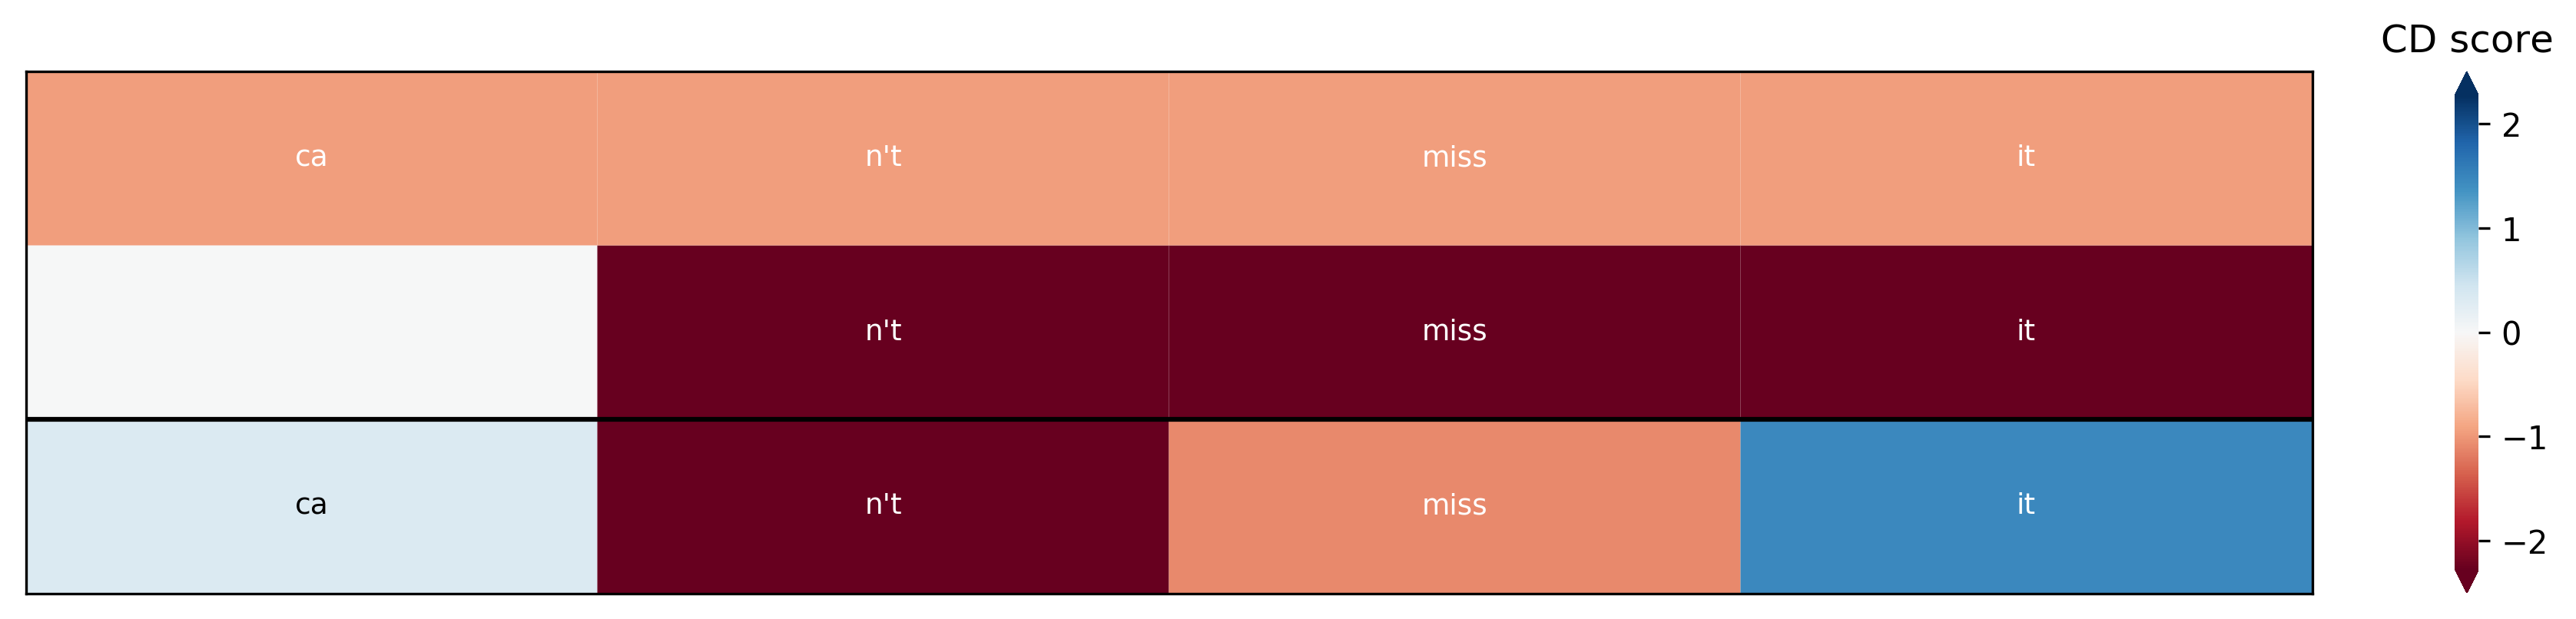

In [42]:
batch_idx =17
label_in_text = lambda x: "positive" if x ==0 else "negative"
# base parameters
sweep_dim = 1 # how large chunks of text should be considered (1 for words)
method = 'cd' # build_up, break_down, cd
percentile_include = 99.5 # keep this very high so we don't add too many words at once
num_iters = 25 # maximum number of iterations (rarely reached)

# text and label
sentence = ['a', 'great', 'ensemble', 'cast', 'ca', 'n\'t', 'lift', 'this', 'heartfelt', 'enterprise', 'out', 'of', 'the', 'familiar', '.'] # note this is a real example from the dataset
sentence = ['not', 'good', ',', 'not', 'bad', ',', 'just', 'okay'] # any text with words from this dataset can be interpreted
sentence = [sst_pkl['itos'][x] for x in incorrect_batches_list[batch_idx]]
label = incorrect_labels_list[batch_idx] 


def batch_from_str_list(s):
    batch = B()
    nums = np.expand_dims(np.array([sst_pkl['stoi'][x] for x in s]).transpose(), axis=1)
    batch.text = torch.LongTensor(nums).to(device) #cuda()
    return batch

# prepare inputs
batch = batch_from_str_list(sentence)
scores_all = model(batch).data.cpu().numpy()[0] # predict
label_pred = np.argmax(scores_all) # get predicted class

# agglomerate
lists = agg.agglomerate(model, batch, percentile_include, method, sweep_dim, # only works for sweep_dim = 1
                    label_pred, num_iters=num_iters, device=device) # see agg_1d.agglomerate to understand what this dictionary contains
lists = agg.collapse_tree(lists) # don't show redundant joins

# visualize
viz.word_heatmap(sentence, lists, label_pred, label, fontsize=9)
print(label_in_text(label))